In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy 
import seaborn as sns 

In [2]:
def sqmat2vec(sqmat, upperORlower='upper'):
    """
    extracts the upper or lower triangular part of a square matrix and return as a vector

    """

    if upperORlower == 'upper':
        coords = np.where(np.triu(np.ones(sqmat.shape), k=1) > 0)
    else:
        coords = np.where(np.tril(np.ones(sqmat.shape), k=1) > 0)

    vec = sqmat[coords]
    return vec

In [3]:
K1 = 30     # conditions for projection 1 
K2 = 20     # conditions for projection 2  
N1 = 8000   # number of time points for data 1
N2 = 8000   # number of time points for data 2
P = 100     # number of channels

n_simulations = 1000 
np.random.seed(0) 

In [4]:
# spatial structure 
sigma1 = 10 * np.random.randn(P, P) 
sigma1 = sigma1 ** 2 
sigma1 = scipy.ndimage.gaussian_filter(sigma1, 2)
sigma1 = (sigma1 + sigma1.T) / 2 
M1 = np.real(scipy.linalg.sqrtm(sigma1))
Y1 = np.random.randn(N1, P) @ M1

sigma2 = 10 * np.random.randn(P, P) 
sigma2 = sigma2 ** 2 
sigma2 = scipy.ndimage.gaussian_filter(sigma2, 2)
sigma2 = (sigma2 + sigma2.T) / 2 
M2 = np.real(scipy.linalg.sqrtm(sigma2))
Y2 = np.random.randn(N2, P) @ M2 

In [5]:
## corrs of simmat on the original time series 
# topo1 = sqmat2vec(np.corrcoef(Y1.T))
# topo2 = sqmat2vec(np.corrcoef(Y2.T))
topo1 = sqmat2vec(np.corrcoef((Y1 - Y1.mean(axis=0, keepdims=True)).T))
topo2 = sqmat2vec(np.corrcoef((Y2 - Y2.mean(axis=0, keepdims=True)).T))

corr_original_time_series = np.corrcoef([topo1, topo2])[0, 1]
corr_original_time_series 

0.31350621960577757

In [6]:
a = np.random.choice(5, 10, True) 
a 

array([0, 1, 3, 2, 4, 0, 2, 1, 4, 4])

In [7]:
b = np.zeros((5, 10))
b[a, np.arange(10)] = 1 
b 

array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 1.]])

In [8]:
np.divide(b, b.sum(axis=1, keepdims=True)) 

array([[0.5       , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.5       , 0.        ,
        0.        , 0.5       , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.        , 0.33333333, 0.33333333]])

In [9]:
corrs_same_projections = []
corrs_diff_projections = [] 

for simI in np.arange(n_simulations): 
    inds_Y1 = np.random.choice(K1, N1, True)
    design_mat1 = np.zeros((K1, N1)) 
    design_mat1[inds_Y1, np.arange(N1)] = 1 
    design_mat1 = np.divide(design_mat1, design_mat1.sum(axis=1, keepdims=True))

    inds_Y2 = np.random.choice(K2, N2, True)
    design_mat2 = np.zeros((K2, N2)) 
    design_mat2[inds_Y2, np.arange(N2)] = 1 
    design_mat2 = np.divide(design_mat2, design_mat2.sum(axis=1, keepdims=True))

    # same projects
    y1 = design_mat1 @ Y1 
    y2 = design_mat1 @ Y2 
    
    # topo1 = sqmat2vec(np.corrcoef(y1.T))
    # topo2 = sqmat2vec(np.corrcoef(y2.T))
    topo1 = sqmat2vec(np.corrcoef((y1 - y1.mean(axis=0, keepdims=True)).T))
    topo2 = sqmat2vec(np.corrcoef((y2 - y2.mean(axis=0, keepdims=True)).T))

    corrs_same_projections.append(np.corrcoef([topo1, topo2])[0, 1])

    # diff projects
    y1 = design_mat1 @ Y1 
    y2 = design_mat2 @ Y2 
    
    # topo1 = sqmat2vec(np.corrcoef(y1.T))
    # topo2 = sqmat2vec(np.corrcoef(y2.T))
    topo1 = sqmat2vec(np.corrcoef((y1 - y1.mean(axis=0, keepdims=True)).T))
    topo2 = sqmat2vec(np.corrcoef((y2 - y2.mean(axis=0, keepdims=True)).T))

    corrs_diff_projections.append(np.corrcoef([topo1, topo2])[0, 1])

In [10]:
results = {'same': corrs_same_projections,
           'diff': corrs_diff_projections}

<Axes: >

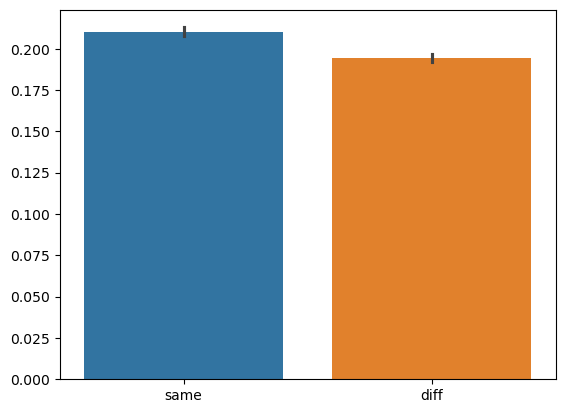

In [11]:
sns.barplot(results, errorbar='se')

In [12]:
scipy.stats.ttest_ind(corrs_same_projections, corrs_diff_projections, nan_policy='omit')  

TtestResult(statistic=4.295778354580895, pvalue=1.8243301370383863e-05, df=1998.0)

So - imagine you have raw time series data Y1, Y2 from 2 different tasks. You define a set of task conditions for each task and compute response profiles for each task. Then you compare the channel x channel response profile similarity matrix between tasks.

When the number of conditions are the same for each task: whether you define the task conditions similarly or differently, the resulting similarities in topography are indistinguishable. 

When the number of conditions are different: there might be a significant difference in the similarity of topography, mostly when the difference in # conditions is huge.  

In [13]:
scipy.stats.ttest_1samp(corrs_diff_projections, corr_original_time_series, nan_policy='omit') 

TtestResult(statistic=-45.046492090240555, pvalue=8.337050301536749e-243, df=999)

In [14]:
np.log(N1) / 0.5**2 

35.94878728264789